In [145]:
#!pip install neuralforecast

# **LIBRARY PREPARATION**

In [146]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import MLP, FEDformer
from neuralforecast.losses.pytorch import MQLoss, DistributionLoss, MSE, MAE
from neuralforecast.tsdataset import TimeSeriesDataset

from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from scipy.signal import savgol_filter

# **DIG DATA PREPARATION**

In [147]:
# Read Data
df = pd.read_csv('DIG Historical Data 1_6 Fed.csv')

In [148]:
# Add ID constraint
df1 = df
df1['unique_id'] = 'DIG'

# Reorder columns
df1 = df1[['unique_id', 'Date', 'Price']]

# Rename
df1.rename(columns={'Date': 'ds', 'Price': 'y'}, inplace=True)
df1

,unique_id,ds,y
0,DIG,2018-01-02,11033.20
1,DIG,2018-01-03,11457.60
2,DIG,2018-01-04,12094.10
3,DIG,2018-01-05,12094.10
4,DIG,2018-01-06,11669.75
...,...,...,...
2338,DIG,2024-05-28,27850.00
2339,DIG,2024-05-29,27950.00
2340,DIG,2024-05-30,27600.00
2341,DIG,2024-05-31,27750.00


In [149]:
# Change Data Type
df1['ds'] = pd.to_datetime(df1['ds'])
df1['y'] = df1['y'].astype(float)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2343 entries, 0 to 2342
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   unique_id  2343 non-null   object        
 1   ds         2343 non-null   datetime64[ns]
 2   y          2343 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 55.0+ KB


# **TRAIN-TEST SPLIT**

In [150]:
# Sizing
size = int(len(df1))

# 7 : 3 Ratio
train_data = df1[:int(0.7 *size)]
test_data = df1[int(0.7 * size):]
train_len = len(train_data)
test_len = len(test_data)
print("Training lenght:" , train_len)
print("Test lenght:" , test_len)

Training lenght: 1640
Test lenght: 703


In [151]:
# Train_data MAX Value
train_data.max()

unique_id                    DIG
ds           2022-06-29 00:00:00
y                        98196.7
dtype: object

# **TRAINING PROCESSS**

In [152]:
# Model Configuration
model = FEDformer(
    h=test_len + 90,
    input_size = 120,  # 120 Days of input size
    modes=64,  # Reduced modes for less complexity
    hidden_size=128,  # Increased hidden size
    n_head=8,  # Must be set to 8
    loss=MAE(),
    scaler_type='standard',  # Change the scaler type
    learning_rate=1e-3,  # Fine-tune the learning rate
    max_steps=100,  # Increase the number of training steps
    batch_size=32,  # Adjust batch size
    windows_batch_size=256,  # Adjust window batch size
)

nf = NeuralForecast(
    models=[model],
    freq='D',
)

INFO:lightning_fabric.utilities.seed:Seed set to 1


In [153]:
# Training
nf.fit(df=train_data, static_df=None, verbose=True)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | loss          | MAE           | 0      | train
1 | padder_train  | ConstantPad1d | 0      | train
2 | scaler        | TemporalNorm  | 0      | train
3 | decomp        | SeriesDecomp  | 0      | train
4 | enc_embedding | DataEmbedding | 384    | train
5 | dec_embedding | DataEmbedding | 384    | train
6 | encoder       | Encoder       | 271 K  | train
7 | decoder       | Decoder       | 403 K  | train
--------------------------------------------------------
675 K     Trainable params
0         Non-trainable 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


# **PREDICTION**


In [154]:
forecasts = nf.predict()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/neuralforecast/core.py:196: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [155]:
# Reset Index
train = train_data['y']
test = test_data['y']

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

predict = forecasts['FEDformer']
predict.reset_index(drop=True, inplace=True)

In [156]:
predict_test = predict[0:test_len]
predict_future = predict[test_len:]

In [157]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [158]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
703    232673.937500
704    218292.312500
705    188652.281250
706    218302.718750
707    195129.390625
708    204092.828125
709    244243.375000
710    246046.250000
711    270186.343750
712    237479.765625
713    240481.796875
714    232874.218750
715    229470.484375
716    275964.187500
717    228075.062500
718    251731.312500
719    261436.312500
720    206460.937500
721    207025.937500
722    189242.375000
723    207723.671875
724    205117.812500
725    254535.265625
726    239144.968750
727    209852.890625
728    216469.796875
729    247561.296875
730    212972.765625
731    241609.937500
732    208144.156250
Name: FEDformer, dtype: float32

Predicted Data for the next 60 days:
733    212327.578125
734    229006.609375
735    215396.687500
736    184882.562500
737    197301.750000
738    200655.593750
739    187134.234375
740    176330.796875
741    219708.109375
742    228186.000000
743    231497.515625
744    237122.937500
745    257

# **EVALUATION**

In [159]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 107207.86067486073
Mean Absolute Percentage Error (MAPE): 4.66524302372584
Mean Square Error (MSE): 14742179419.830109
Root Mean Square Error (RMSE): 121417.3769269873


# **VISUALIZATION**

In [160]:
# prompt: adding first_value to the last of test
first_value = predict_test.iloc[0]
train_draw = pd.concat([train, pd.Series([first_value])], ignore_index=True)

**Overall Visualization**

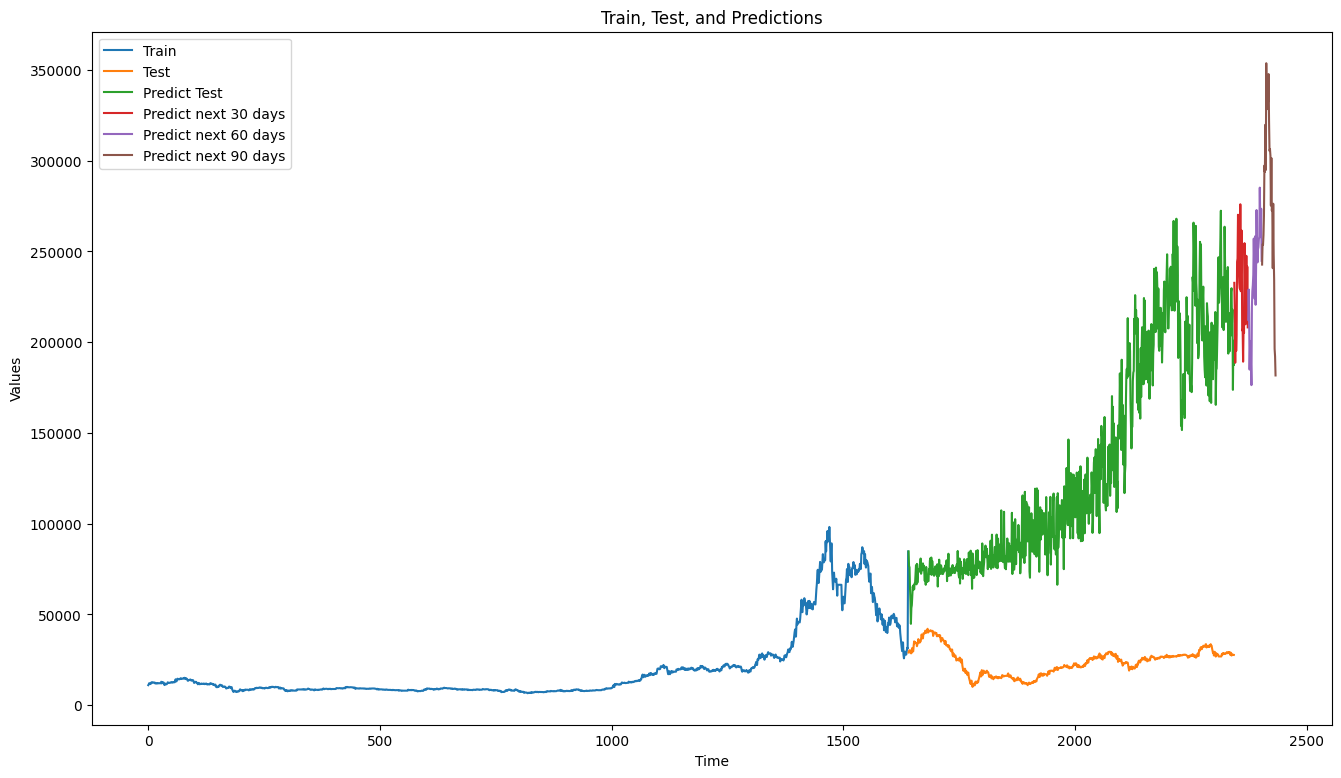

In [161]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Train, Test, and Predictions')
plt.show()

# **---------------------------------------**

# **POLYNOMINAL SMOOTHING**

In [162]:
predict_smoothed = savgol_filter(predict, window_length=31, polyorder=3)

# **RE - PREDICTION**


In [163]:
predict_test = predict_smoothed[0:test_len]
predict_future = predict_smoothed[test_len:]

In [164]:
# Order predict_future
predict_future_30 = predict_future[:30]
predict_future_60 = predict_future[30:60]
predict_future_90 = predict_future[60:]

In [165]:
# Print Predicted Data
print("\nPredicted Data for the next 30 days:")
print(predict_future_30)

print("\nPredicted Data for the next 60 days:")
print(predict_future_60)

print("\nPredicted Data for the next 90 days:")
print(predict_future_90)


Predicted Data for the next 30 days:
[210227.34 212436.06 218087.86 221100.64 225451.64 227953.86 229470.52
 229100.27 229339.4  232081.16 234530.62 234644.38 236754.64 234922.39
 235427.39 234330.77 234266.73 234073.4  233143.38 232138.5  229114.9
 226272.3  225214.02 222068.84 220271.58 217363.16 214819.64 211590.28
 209486.14 211237.4 ]

Predicted Data for the next 60 days:
[209787.23 211914.3  214267.1  213164.77 213484.19 213353.17 213718.05
 213974.14 216881.8  219712.02 220406.72 222718.05 227477.17 230250.14
 236084.   240360.89 244077.28 248617.28 252256.81 253648.36 254135.31
 255006.11 253997.08 253414.66 252212.48 253333.84 254849.08 257224.52
 261161.   264337.28]

Predicted Data for the next 90 days:
[268100.97 274263.8  278266.44 282914.2  290063.8  294611.6  299528.44
 303791.94 308706.88 311077.66 313969.06 317828.97 321365.9  322859.22
 323841.97 321304.9  317688.9  313005.12 307264.62 300478.53 292657.94
 283813.97 273957.7  263100.22 251252.67 238426.14 224631.72 2

# **RE - EVALUATION**

In [166]:
mae = mean_absolute_error(test, predict_test)
mape = mean_absolute_percentage_error(test, predict_test)
mse = mean_squared_error(test, predict_test)
rmse = np.sqrt(mean_squared_error(test, predict_test))

print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Mean Square Error (MSE):", mse)
print("Root Mean Square Error (RMSE):", rmse)

Mean Absolute Error (MAE): 107217.07130119429
Mean Absolute Percentage Error (MAPE): 4.665251869425645
Mean Square Error (MSE): 14541798629.399714
Root Mean Square Error (RMSE): 120589.3802513294


# **RE - VISUALIZATION**

In [167]:
# Assuming predict_test is a NumPy array
first_value = pd.Series(predict_test.reshape(-1))  # Convert to pandas Series

# Concatenate train and first_value as Series in a new DataFrame
train_draw = pd.concat([train, first_value], ignore_index=True)

**Overall Visualization**

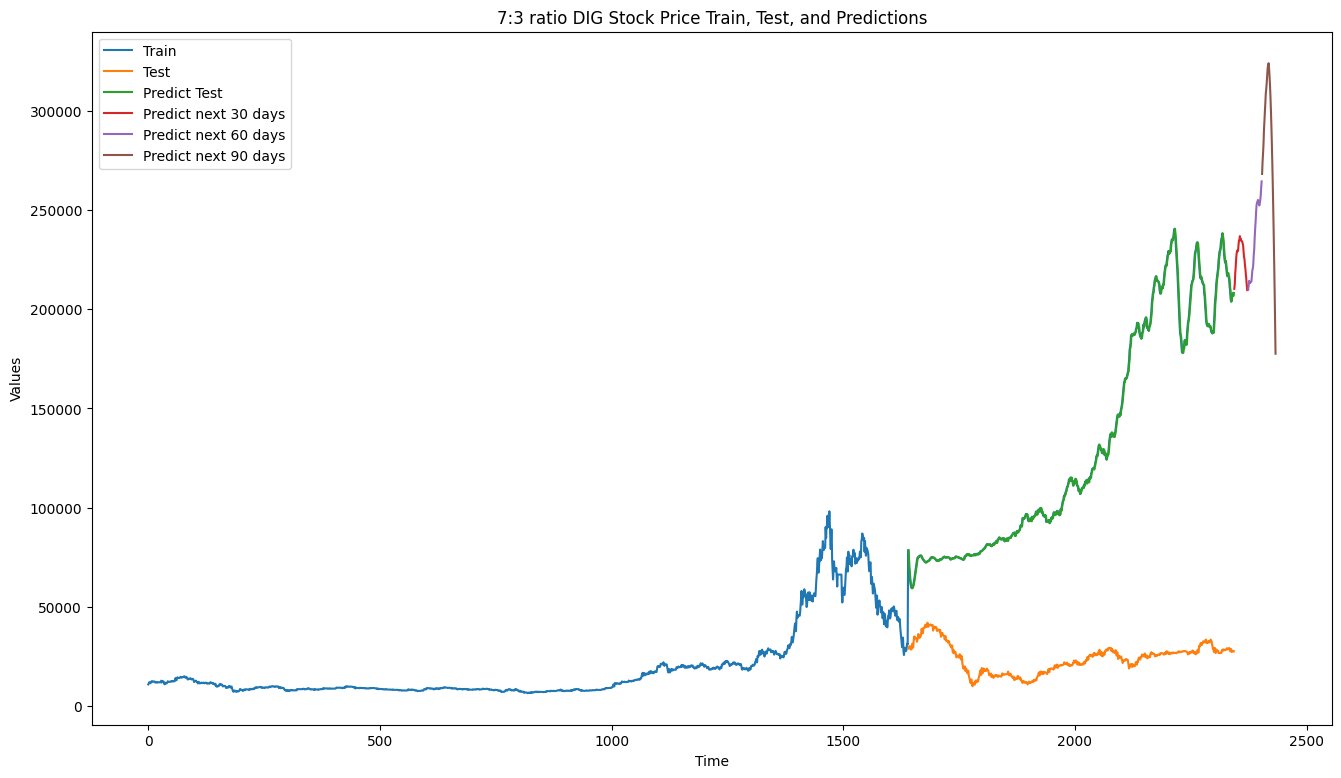

In [168]:
plt.figure(figsize=(16, 9))

train_data_index = pd.RangeIndex(start=0, stop=train_len+1, step=1)
plt.plot(train_draw)
test_data_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(test_data_index, test)

predict_test_index = pd.RangeIndex(start=train_len+1, stop=train_len+test_len+1, step=1)
plt.plot(predict_test_index,(predict_test))

predict_future_30_index = pd.RangeIndex(start=train_len+test_len+1, stop=train_len+test_len+31, step=1)
plt.plot(predict_future_30_index, predict_future_30)
predict_future_60_index = pd.RangeIndex(start=train_len+test_len+31, stop=train_len+test_len+61, step=1)
plt.plot(predict_future_60_index, predict_future_60)
predict_future_90_index = pd.RangeIndex(start=train_len+test_len+61, stop=train_len+test_len+91, step=1)
plt.plot(predict_future_90_index, predict_future_90)

plt.legend(['Train', 'Test', 'Predict Test', 'Predict next 30 days', 'Predict next 60 days', 'Predict next 90 days'])
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('7:3 ratio DIG Stock Price Train, Test, and Predictions')
plt.show()